### Laboratorio 7 - Predicción de Diabetes con AutoGluon

Stefano Aragoni, Carol Arevalo

------

El <font color=orange>objetivo de este ejercicio es construir, entrenar y probar un modelo clasificador para predecir diabetes en pacientes usando AutoGluon</font>. Esta herramienta puede ser utilizada de manera efectiva por profesionales de la salud para detectar diabetes y entender los factores clave que contribuyen a la enfermedad.

-------

En este laboratorio, se utilizó el dataset diabetes.csv, el cual contiene 9 columnas y 768 registros. La columna Outcome es la variable objetivo, la cual indica si el paciente tiene diabetes o no. Las otras 8 columnas son variables independientes que se utilizarán para predecir la variable objetivo.

##### *Importar librerías*

Como primer paso, se importaron las librerías necesarias para el desarrollo del laboratorio.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

-----------

##### *Cargar el Conjunto de Datos*

Posteriormente, se cargó el conjunto de datos diabetes.csv en un dataframe de pandas. Como se puede observar, hay presentes 9 columnas. La columna Outcome es la variable objetivo, la cual indica si el paciente tiene diabetes o no. Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction y Age son las variables que se utilizarán para predecir la variable objetivo.

In [58]:
# Crear un DataFrame con el contenido
df = pd.read_csv('diabetes.csv')

# Explorar las primeras 5 filas del DataFrame
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


----------

##### *Análisis Exploratorio de Datos (EDA)*

Como primer paso del análisis exploratorio, se <font color=orange>obtuvo estadísticas descriptivas básicas de las variables del conjunto de datos</font>.

En este caso, se puede observar valores normales y esperados. Sin emabrgo, en algunas columas se puede observar que hay valores que no tienen sentido. Por ejemplo, la presión sanguínea no puede ser 0. Asimismo, el BMI no puede ser 0.

In [59]:
# Estadísticas descriptivas básicas
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Asimismo, como se puede observar, todos las columnas almacenan valores numéricos, por lo que no es necesario realizar un proceso de codificación de variables categóricas.

In [60]:
# Obtener información del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Como segundo paso, se realizó una <font color=orange>visualización de la distribución de las variables del conjunto de datos</font>.


Nuevamente, se pueden observar ciertos datos extraños. Por ejemplo, BloodPressure, Glucose, BMI tienen valores con 0. Esto no es posible, por lo que se deben limpiar los datos.

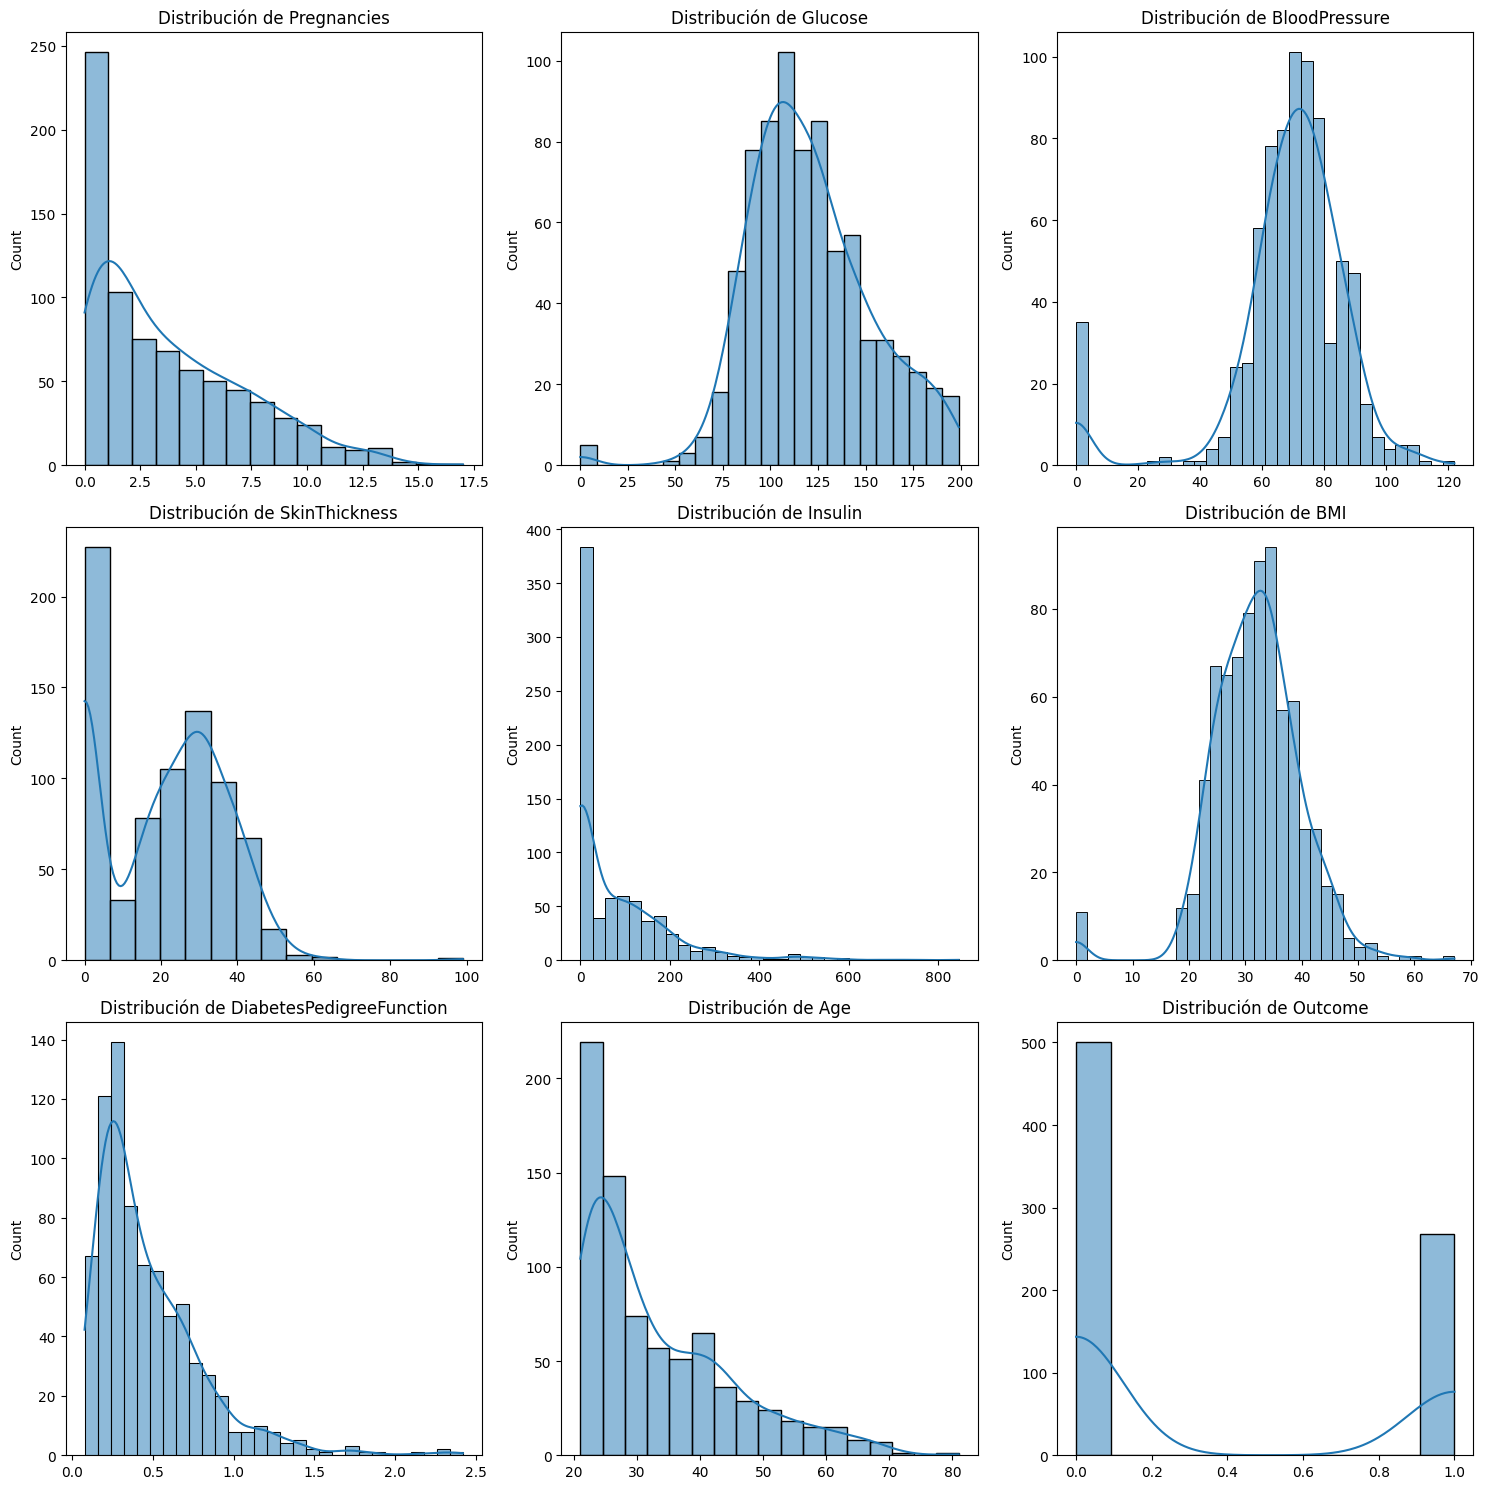

In [61]:
# Graficar la distribución de cada variable

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
df_values = df.values
columns = df.columns

# Iterar a través de las filas y columnas de la cuadrícula
for i in range(3):
    for j in range(3):
        column = columns[i * 3 + j]
        sns.histplot(df_values[:, i * 3 + j], kde=True, ax=axes[i, j])
        axes[i, j].set_title(f'Distribución de {column}')

plt.tight_layout()
plt.show()

Asimismo, en términos generales, se puede observar algunos pocos valores atípicos en las variables.

En el caso de la insulina, se puede observar que hay muchos valores atípicos. Sin emabrgo, NO SE LIMPIARÁN estos datos atípicos, ya que se considera que son valores válidos. En realidad, son buenos indicadores de la presencia de diabetes.

<Axes: >

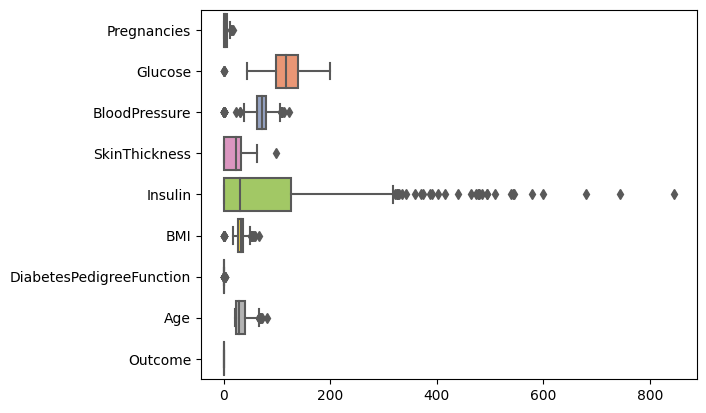

In [62]:
# Ver datos atipicos
sns.boxplot(data=df, orient='h', palette='Set2')

Tomando en cuenta lo que se observó en el análisis exploratorio de datos, se procedió a limpiar los datos.
Más específicamente, se remplazó los valores 0 por NaN en las columnas Glucose, BloodPressure, y BMI. Esto debido a que dichas columnas no pueden tener valores 0.

In [63]:
# Reemplazar los valores 0 por NaN en las columnas Glucose, BloodPressure, y BMI

df[['Glucose', 'BloodPressure', 'BMI']] = df[['Glucose', 'BloodPressure', 'BMI']].replace(0, np.nan)

Como tercer y último paso, se <font color=orange>verificó la existencia valores nulos en el conjunto de datos</font>. Sin embargo, debido a que se remplazó los valores 0 por NaN, se puede observar que hay valores nulos en las columnas Glucose, BloodPressure, y BMI.

<Axes: >

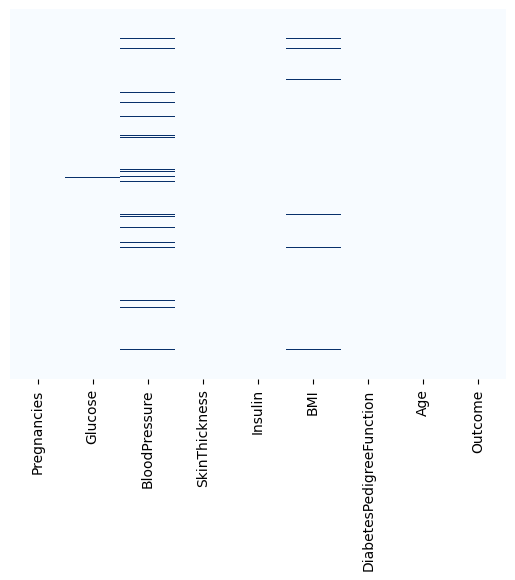

In [64]:
# Verificación de valores nulos
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

Sin embargo, en este caso la cantidad de registros con valores nulos es muy pequeña, por lo que se procedió a eliminar los registros con valores nulos. En realidad, es aproximadamente 5% de los registros, por lo que se puede eliminar sin afectar el modelo.

Porcentaje de filas con valores nulos:
5.729166666666666


<Axes: >

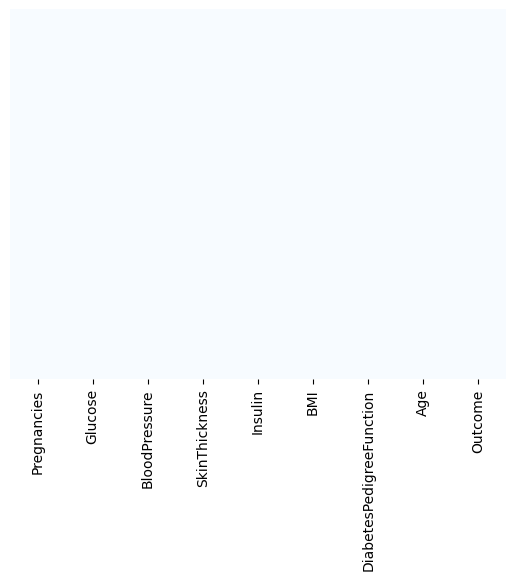

In [65]:
# % de filas con valores nulos
print('Porcentaje de filas con valores nulos:')
print(df.isnull().any(axis=1).sum() / len(df) * 100)


# Eliminar las filas con valores nulos
df = df.dropna()

# Verificación de valores nulos
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

-------------

##### *Entrenamiento con AutoGluon*

Con los datos limpios, se procedió a entrenar el modelo con AutoGluon. Para ello, se dividió el conjunto de datos en 80% para entrenamiento y 20% para prueba.

In [66]:
# Dividir los datos en un 80% para entrenamiento y 20% para pruebas

X_entreno, X_prueba = train_test_split(df, test_size=0.2, random_state=0)

Asimismo, cabe destacar que se utilizó la opción `best_quality` de preset y la métrica `accuracy`. Asimismo, se busca entrenar modelos de clasificación con AutoGluon para predecir la columna "Outcome".

In [67]:
predictor = TabularPredictor(label="Outcome",
                             problem_type = 'binary',
                             eval_metric = 'accuracy').fit(X_entreno,
                                                           time_limit=500,
                                                           presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20231012_233939/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 500s
AutoGluon will save models to "AutogluonModels/ag-20231012_233939/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   80.00 GB / 115.66 GB (69.2%)
Train Data Rows:    579
Train Data Columns: 8
Label Column: Outcome
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10776.44 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to ma

-------------

##### *Evaluación del Modelo*

Posterior al entrenamiento, se quizo <font color=orange>desplegar una tabla de los mejores modelos (leaderboard) en función de la
precisión</font>. Como se puede observar, el mejor modelo es <font color=green>WeightedEnsemble_L2</font>, el cual tiene una precisión de 0.7823. Esto quiere decir que el modelo es capaz de predecir correctamente el 78.23% de los casos.

Cabe destacar que todos los modelos tienen una precisión mayor a 0.70, lo cual es un buen indicador. En realidad, de 7 modelos, solo 2 tienen una precisión menor a 0.75.

                     model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2   0.782383       0.473651  3.004428                0.001827           0.552936            2       True          7
1    ExtraTreesEntr_BAG_L1   0.772021       0.138850  0.731662                0.138850           0.731662            1       True          6
2  RandomForestGini_BAG_L1   0.770294       0.128806  0.794770                0.128806           0.794770            1       True          3
3  RandomForestEntr_BAG_L1   0.768566       0.129061  0.825436                0.129061           0.825436            1       True          4
4    ExtraTreesGini_BAG_L1   0.763385       0.204169  0.925061                0.204169           0.925061            1       True          5
5    KNeighborsDist_BAG_L1   0.718480       0.013560  0.004224                0.013560           0.004224            1       True          2
6    KNeighbo

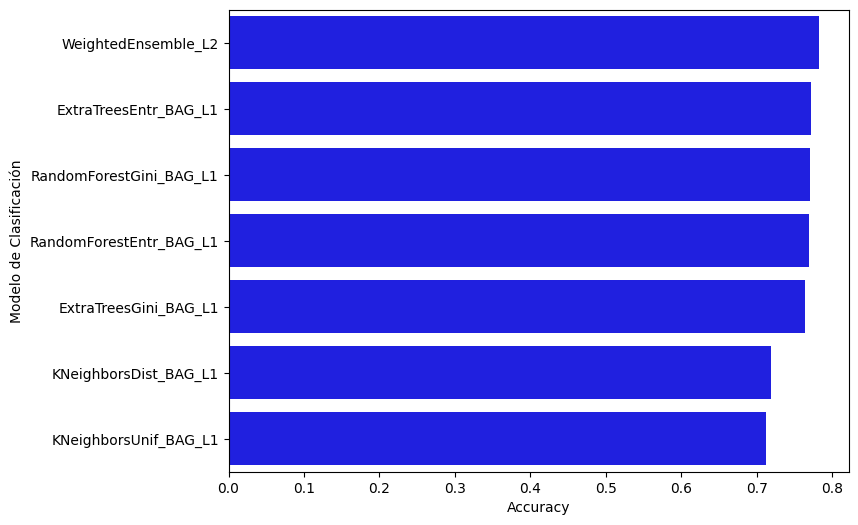

In [68]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="score_val", y="model", data=predictor.leaderboard(), color="b")
ax.set(xlabel="Accuracy", ylabel="Modelo de Clasificación")
plt.xticks(rotation=0)
plt.show()

Finalmente, se procedió a evaluar el modelo con el conjunto de datos de prueba. A continuación se muestra la <font color=orange>matriz de confusión del *mejor modelo* **WeightedEnsemble_L2** </font> y las métricas de precisión, recall y F1.

Según la matriz de confusión, de los 145 ejemplos evaluados, el modelo logró clasificar correctamente 79 como verdaderos negativos y 32 como verdaderos positivos, lo que representa instancias clasificadas de manera precisa en ambas clases. Sin embargo, se observaron 18 falsos positivos y 16 falsos negativos, lo que indica que el modelo cometió errores al clasificar algunas instancias.

En términos de accuracy, el modelo tuvo un rendimiento de 77%. Esto quiere decir que fue capaz de clasificar correctamente si un paciente tiene diabetes o no en el 77% de los casos de prueba.

En conclusión, el modelo tiene un buen rendimiento, ya que fue capaz de clasificar correctamente la mayoría de los casos de prueba. 

In [69]:
y_prueba = X_prueba['Outcome']
y_pred = predictor.predict(X_prueba)
cm = confusion_matrix(y_prueba, y_pred)

# Print the confusion matrix
print("Matriz de Confusión:")
print(cm)

# Print classification report with additional metrics
print("\nReporte - Métricas:")
print(classification_report(y_prueba, y_pred))



Matriz de Confusión:
[[79 18]
 [16 32]]

Reporte - Métricas:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        97
           1       0.64      0.67      0.65        48

    accuracy                           0.77       145
   macro avg       0.74      0.74      0.74       145
weighted avg       0.77      0.77      0.77       145



-------------

##### *Reflexión*

- Redactar sus reflexiones sobre su experiencia en la última semana en este curso y su opinión sobre el paquete AutoGluon. ¿Qué ventajas y desventajas pueden verse en este tipo de herramientas de "AutoML"?

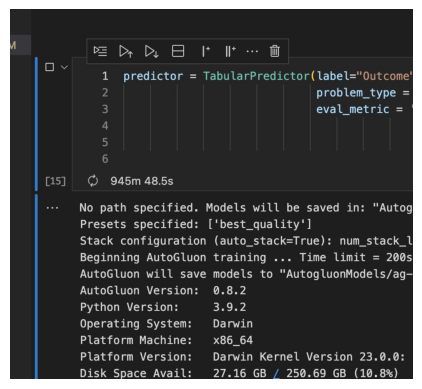

In [4]:
img = plt.imread('ejecucion.jpeg')
plt.imshow(img)
plt.axis('off')
plt.show()